In [31]:
import os
os.chdir('/home/lewis/PhD/compounds-research')
import matplotlib.pyplot as plt
from matplotlib import cm
import numpy as np
from importlib import reload
import datetime as dt

from compounds_research.compound.utils import make_rates_df, make_original_df
from simulator.engine import dai_rate_model
from simulator.engine.dai_rate_params import PARAM_REGIMES, PARAM_REGIME_NUMS
%matplotlib inline

In [32]:
regime_number = '5'

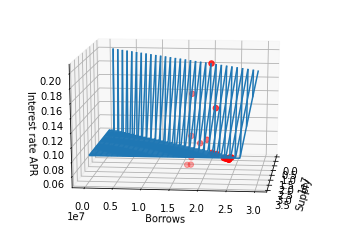

In [33]:
#BORROW RATES

fig = plt.figure()
ax = fig.gca(projection='3d')

#Model
reserves = 0 # Arbitrary
supply = np.arange(0, 30000000, 100000)
borrows = np.arange(0, 30000000, 100000)
S, B = np.meshgrid(supply, borrows)

br_dict = {}
r_upscaled = reserves * int(1e18)
for b in borrows:
    b_upscaled = int(b) * int(1e18)
    for s in supply:
        if s<b:
            continue
        s_upscaled = int(s) * int(1e18)
        cash_upscaled = s_upscaled - b_upscaled + r_upscaled
        br = dai_rate_model.get_borrow_rate(cash=cash_upscaled, borrows=b_upscaled, reserves=r_upscaled, regime_params=PARAM_REGIMES[PARAM_REGIME_NUMS[regime_number]])
        br_downscaled_APR = (br) / int(1e18)* dai_rate_model.BLOCKS_PER_YEAR
        # util = dai_rate_model.utilization_rate(cash = cash_upscaled, borrows=b_upscaled, reserves=r_upscaled) / int(1e18)
        br_dict[(s_upscaled,b_upscaled)] = br_downscaled_APR
        
Z_br = np.empty((300,300))
Z_br[:] = np.NaN

for key in br_dict:
    i = int(key[0] / int(1e23))
    j = int(key[1] / int(1e23))
    Z_br[j][i] = br_dict[key]

ax.plot_wireframe(X=S, Y=B, Z=Z_br, rcount = 30, ccount= 30, antialiased=True)

#Actual
df_cdai = make_original_df(token='cdai', resampling_frequency='D')
df_cdai = df_cdai[df_cdai['regime'] == float(regime_number)]

S_o = df_cdai['total_supply_history']
B_o = df_cdai['total_borrows_history']
Z_o = df_cdai['borrow_rates']
ax.scatter(S_o, B_o, Z_o, zdir='z', s=30, c='r', marker='o', depthshade=True)

ax.set_xlabel('Supply')
ax.set_ylabel('Borrows')
ax.set_zlabel('Interest rate APR')
ax.view_init(elev=15, azim=6)
fig.savefig('../overleaf/5e6bad2e6490390001d3c466/images/compound-observed-borrow.pdf', bbox_inches='tight', dpi = 300)
plt.show()

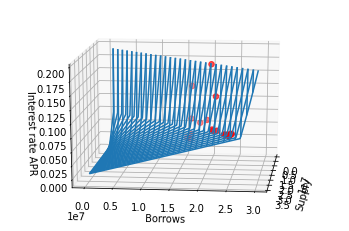

In [34]:
#SUPPLY RATES

fig = plt.figure()
ax = fig.gca(projection='3d')

#Model
sr_dict = {}
r_upscaled = reserves * int(1e18)
for b in borrows:
    b_upscaled = int(b) * int(1e18)
    for s in supply:
        if s<b:
            continue
        s_upscaled = int(s) * int(1e18)
        cash_upscaled = s_upscaled - b_upscaled + r_upscaled
        sr = dai_rate_model.get_supply_rate(cash=cash_upscaled, borrows=b_upscaled, reserves=r_upscaled, reserve_factor=dai_rate_model.RESERVE_FACTOR, regime_params=PARAM_REGIMES[PARAM_REGIME_NUMS[regime_number]])
        sr_downscaled_APR = (sr) / int(1e18)* dai_rate_model.BLOCKS_PER_YEAR
        # util = dai_rate_model.utilization_rate(cash = cash_upscaled, borrows=b_upscaled, reserves=r_upscaled) / int(1e18)
        sr_dict[(s_upscaled,b_upscaled)] = sr_downscaled_APR
        
Z_sr = np.empty((300,300))
Z_sr[:] = np.NaN

for key in sr_dict:
    i = int(key[0] / int(1e23))
    j = int(key[1] / int(1e23))
    Z_sr[j][i] = sr_dict[key]

ax.plot_wireframe(X=S, Y=B, Z=Z_sr, rcount = 30, ccount= 30, antialiased=True)

#Actual
df_cdai = make_original_df(token='cdai', resampling_frequency='D')
df_cdai = df_cdai[df_cdai['regime'] == float(regime_number)]

S_o = df_cdai['total_supply_history']
B_o = df_cdai['total_borrows_history']
Z_o = df_cdai['supply_rates']
ax.scatter(S_o, B_o, Z_o, zdir='z', s=30, c='r', marker='o', depthshade=True)

ax.set_xlabel('Supply')
ax.set_ylabel('Borrows')
ax.set_zlabel('Interest rate APR')
ax.view_init(elev=15, azim=6)
fig.savefig('../overleaf/5e6bad2e6490390001d3c466/images/compound-observed-supply.pdf', bbox_inches='tight', dpi = 300)
plt.show()

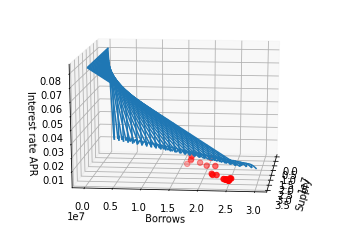

In [35]:
fig = plt.figure()
ax = fig.gca(projection='3d')

#Model
Z_delta = Z_br - Z_sr
ax.plot_wireframe(X=S, Y=B, Z=Z_delta, rcount = 30, ccount= 30, antialiased=True)

#Observed
S_o = df_cdai['total_supply_history']
B_o = df_cdai['total_borrows_history']
Z_o = df_cdai['borrow_rates'] - df_cdai['supply_rates']

ax.scatter(S_o, B_o, Z_o, zdir='z', s=30, c='r', marker='o', depthshade=True)

ax.set_xlabel('Supply')
ax.set_ylabel('Borrows')
ax.set_zlabel('Interest rate APR')
ax.view_init(elev=15, azim=6)
fig.savefig('../overleaf/5e6bad2e6490390001d3c466/images/compound-observed-delta.pdf', bbox_inches='tight', dpi = 300)
plt.show()